# Tutorial 4: Analysis of large-scale Stereo-seq MOBS1 data

The following tutorials demonstrates how to use PAST to derive latent embeddings and decipher spatial domains on Stereo-seq mouse olfactory bulb section1 (MOBS1) dataset([Chen, et al., 2022](https://www.sciencedirect.com/science/article/pii/S0092867422003993)). MOBS1 dataset, containing 107,416 spots and 26,145 genes, is too large to analyze with common ST methods. Here we demonstrate PAST could be applied to MOBS1 data with low time and memory cost.

There are two parts in this tutorial:

+ **Integrating self-prior data to analyze MOBS1 data.** This part will show you how to utilize target preprocessed gene expression matrix as self-prior matrix to obtain latent embeddings and spatial clusters on Stereo-seq MOBS1 data.

+ **Integrating external-prior data to analyze MOBS1 data.** This part will show you how to utilize another mouse olfactory bulb section also generated by Stereo-seq as reference to construct external-prior pseudo-bulk matrix for latent feature extraction and spatial clustering on Stereo-seq MOBS1 data.

In [1]:
import past
import os
import scanpy as sc
import warnings
import torch
import numpy as np
import pandas as pd

In [2]:
warnings.filterwarnings("ignore")
sc.set_figure_params(dpi=80, figsize=(3,3), facecolor="white")
os.environ["R_HOME"] = "/home/lizhen/miniconda3/envs/scTECH-R/lib/R"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Using memory_profiler to record time and memory cost of PAST for training and prediction.

In [3]:
%load_ext memory_profiler

You can uncomment and execute the following command to download the Stereo-seq MOBS1 dataset in AnnData format.

In [4]:
# !wget https://health.tsinghua.edu.cn/software/PAST/data/Stereo-seq_MOBS1.h5ad

In [5]:
## DLPFC DATASET
os.chdir("/home/lizhen/code/PAST/Data")
MOBS1 = sc.read_h5ad(filename="Stereo-seq_MOBS1.h5ad")
MOBS1.var_names_make_unique()
MOBS1

AnnData object with n_obs × n_vars = 107416 × 26145
    obs: 'annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'adjusted_anno'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    obsm: 'spatial'

Next, we filter out genes expressed in less than three spots, follow [the Scanpy vignette](https://scanpy-tutorials.readthedocs.io/en/latest/spatial/basic-analysis.html) for spatial transcriptomics to normalize and logarithmize the count matrix, and then select the top 3000 spatial variable genes based on the [Geary'C Index](https://www.jstor.org/stable/2986645).

In [6]:
MOBS1 = past.preprocess(MOBS1, min_cells=3, n_tops=3000, gene_method="gearyc")

## Integrating self-prior matrix to analyze MOBS1

We set a random seed for all random process for reproducibility.

In [7]:
past.setup_seed(666)
sdata = MOBS1.copy()
sdata

AnnData object with n_obs × n_vars = 107416 × 3000
    obs: 'annotation', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'adjusted_anno'
    var: 'n_cells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'log1p'
    obsm: 'spatial'

We initialize PAST model with `d_lat=50`, `k_neighbors=6`.

In [8]:
PAST_model = past.PAST(d_in=sdata.shape[1], d_lat=50, k_neighbors=6, dropout=0.1).to(device)

Then we train PAST model without specifying external reference data, and PAST will automatically utilize the preprocessed target MOBS1 anndata as self-prior marix.

In [9]:
%time %memit PAST_model.model_train(sdata, epochs=50, lr=1e-3, batchsize=3600, device=device)

Early Stop
Model Converge
peak memory: 5084.41 MiB, increment: 893.14 MiB
CPU times: user 1min 18s, sys: 1min 4s, total: 2min 22s
Wall time: 54.1 s


We can obtain the latent embedding through `output()` function of PAST object, and the latent embedding is stored in `sdata.obsm["embedding"]`.

In [10]:
%time %memit sdata = PAST_model.output(sdata)

peak memory: 6082.00 MiB, increment: 1386.69 MiB
CPU times: user 2min 48s, sys: 37.2 s, total: 3min 25s
Wall time: 1min 53s


The result of mclust and louvain with default parameters is stored in `sdata.obs["mclust"]` and `sdata.obs["Dlouvain"]` respectively.

In [11]:
sdata = past.mclust_R(sdata, num_cluster=sdata.obs["annotation"].nunique(), used_obsm='embedding')
sdata = past.default_louvain(sdata, use_rep="embedding")

R[write to console]:     __  ___________    __  _____________
   /  |/  / ____/ /   / / / / ___/_  __/
  / /|_/ / /   / /   / / / /\__ \ / /   
 / /  / / /___/ /___/ /_/ /___/ // /    
/_/  /_/\____/_____/\____//____//_/    version 5.4.9
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


Evaluation of latent embedding and spatial clustering results.

In [12]:
print("Cross-validation score:", end="\t\t")
acc, kappa, mf1, wf1 = past.svm_cross_validation(sdata.obsm["embedding"], sdata.obs["annotation"])
print("Acc: %.3f, K: %.3f, mF1: %.3f, wF1: %.3f"%(acc.mean(), kappa.mean(), mf1.mean(), wf1.mean()))

print("Mclust metrics:", end="\t\t\t")
ari, ami, nmi, fmi, comp, homo = past.cluster_metrics(sdata, "annotation", "mclust")
print("ARI: %.3f, AMI: %.3f, NMI: %.3f, FMI:%.3f, Comp: %.3f, Homo: %.3f"%(ari, ami, nmi, fmi, comp, homo))

print("Dlouvain metrics:", end="\t\t")
ari, ami, nmi, fmi, comp, homo = past.cluster_metrics(sdata, "annotation", "Dlouvain")
print("ARI: %.3f, AMI: %.3f, NMI: %.3f, FMI:%.3f, Comp: %.3f, Homo: %.3f"%(ari, ami, nmi, fmi, comp, homo))

Cross-validation score:		Acc: 0.739, K: 0.701, mF1: 0.704, wF1: 0.735
Mclust metrics:			ARI: 0.350, AMI: 0.503, NMI: 0.503, FMI:0.428, Comp: 0.499, Homo: 0.507
Dlouvain metrics:		ARI: 0.334, AMI: 0.481, NMI: 0.482, FMI:0.407, Comp: 0.460, Homo: 0.506


Visualization of latent embeddings colored by ground truth and PAST-derived clusters.

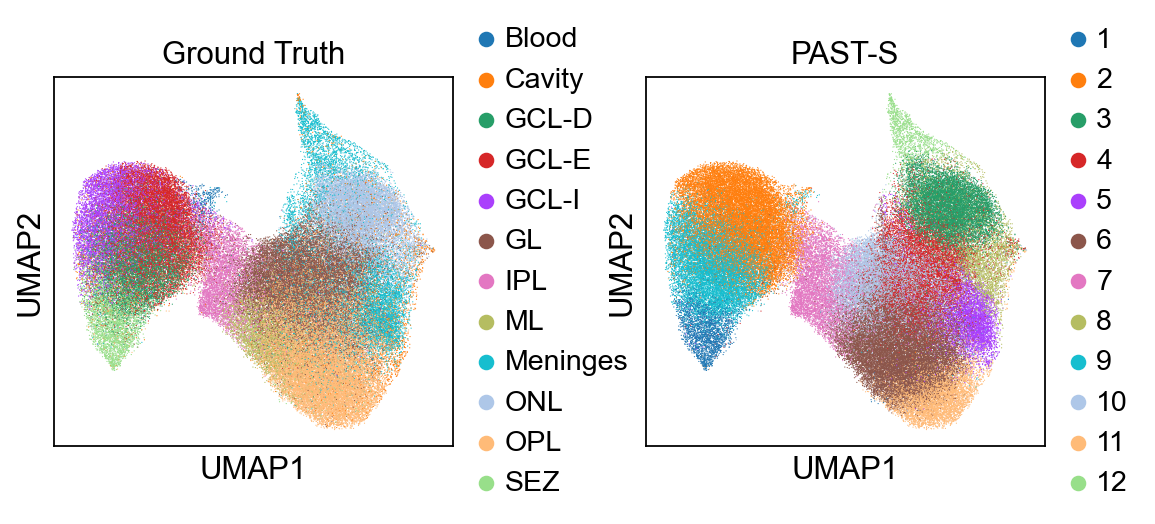

In [13]:
sc.pp.neighbors(sdata, use_rep='embedding')
sc.tl.umap(sdata)
sc.pl.umap(sdata, color=["annotation", "mclust"], title=["Ground Truth", "PAST-S"], wspace=0.35)

Visualization of spatial domains colored by ground truth and PAST-derived clusters.

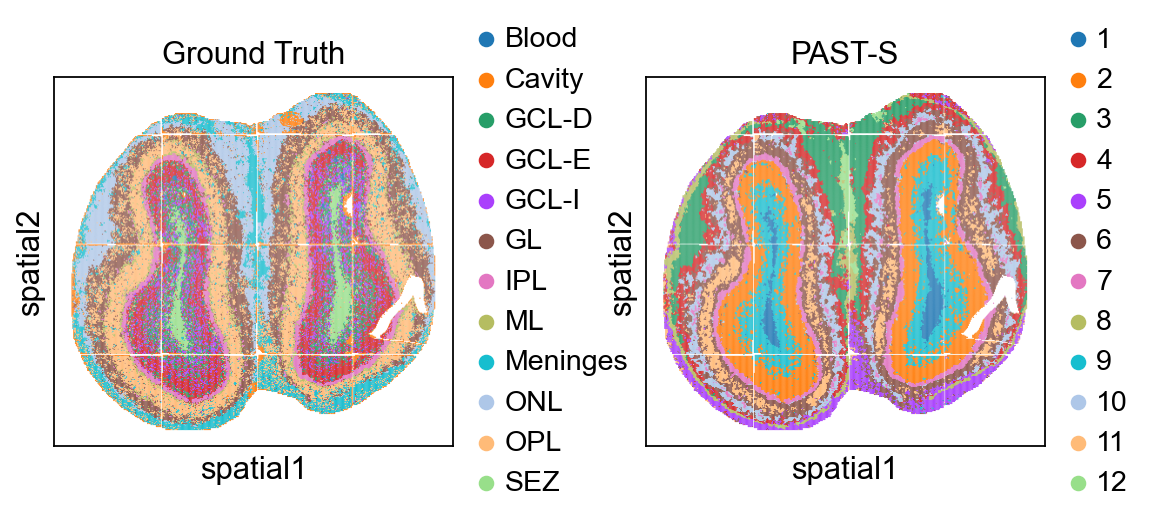

In [14]:
sc.pl.embedding(sdata, color=["annotation", "mclust"], basis="spatial", title=["Ground Truth", "PAST-S"], wspace=0.35)

## Integrating external-prior matrix to analyze MOBS1

Similarly, We set a random seed for all random process for reproducibility.

In [7]:
past.setup_seed(666)
sdata = MOBS1.copy()

Here we utilize another mouse olfactory bulb section2 (MOBS2) dataset([Chen, et al., 2022](https://www.sciencedirect.com/science/article/pii/S0092867422003993)) as reference data, denoted as `rdata`.

In [8]:
# !wget https://health.tsinghua.edu.cn/software/PAST/data/Stereo-seq_MOBS2.h5ad

We first align the gene set of `rdata` to that of `sdata` through `past.integration()` function, preprocess `rdata`, and then construct pseudo-bulk external-prior matrix using `past.get_bulk()` function based on spatial domain labels of reference data.

In [9]:
os.chdir("/home/lizhen/code/PAST/Data")
rdata = sc.read_h5ad(filename="Stereo-seq_MOBS2.h5ad")
rdata = past.integration(rdata, sdata)
rdata = past.preprocess(rdata, min_cells=None, target_sum=None, n_tops=None)
rdata = past.get_bulk(rdata, key="annotation")
rdata

add 597 zero features to reference; Current total 3000 genes
bulk_data's shape: (11, 3000)


AnnData object with n_obs × n_vars = 11 × 3000

We initialize PAST model with the same parameters.

In [10]:
PAST_model = past.PAST(d_in=sdata.shape[1], d_lat=50, k_neighbors=6, dropout=0.1).to(device)

Then we use `rdata` to construct external-prior matrix, and `rdata` should contain raw count gene expression matrix of tissues related to the target data. Besides, users need to specify the `anno_key` stored in `rdata.obs` because the construction of external-prior pseudo-bulk matrix also requires fine annotation of each spot.

In [11]:
%time %memit PAST_model.model_train(sdata, rdata=rdata, epochs=50, lr=1e-3, batchsize=3600, device=device)

Early Stop
Model Converge
peak memory: 5083.49 MiB, increment: 868.48 MiB
CPU times: user 1min 3s, sys: 28.2 s, total: 1min 32s
Wall time: 47.5 s


We then obtain the latent embedding through `output()` function of PAST object, and the latent embedding is stored in `sdata.obsm["embedding"]`.

In [12]:
%time %memit sdata = PAST_model.output(sdata)

peak memory: 6065.48 MiB, increment: 1371.46 MiB
CPU times: user 2min 46s, sys: 36.8 s, total: 3min 23s
Wall time: 1min 52s


The result of mclust and louvain with default parameters is stored in `sdata.obs["mclust"]` and `sdata.obs["Dlouvain"]` respectively.

In [13]:
sdata = past.mclust_R(sdata, num_cluster=sdata.obs["annotation"].nunique(), used_obsm='embedding')
sdata = past.default_louvain(sdata, use_rep="embedding")

R[write to console]:     __  ___________    __  _____________
   /  |/  / ____/ /   / / / / ___/_  __/
  / /|_/ / /   / /   / / / /\__ \ / /   
 / /  / / /___/ /___/ /_/ /___/ // /    
/_/  /_/\____/_____/\____//____//_/    version 5.4.9
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |======================================================================| 100%


Evaluation of latent embedding and spatial clustering results.

In [14]:
print("Cross-validation score:", end="\t\t")
acc, kappa, mf1, wf1 = past.svm_cross_validation(sdata.obsm["embedding"], sdata.obs["annotation"])
print("Acc: %.3f, K: %.3f, mF1: %.3f, wF1: %.3f"%(acc.mean(), kappa.mean(), mf1.mean(), wf1.mean()))

print("Mclust metrics:", end="\t\t\t")
ari, ami, nmi, fmi, comp, homo = past.cluster_metrics(sdata, "annotation", "mclust")
print("ARI: %.3f, AMI: %.3f, NMI: %.3f, FMI:%.3f, Comp: %.3f, Homo: %.3f"%(ari, ami, nmi, fmi, comp, homo))

print("Dlouvain metrics:", end="\t\t")
ari, ami, nmi, fmi, comp, homo = past.cluster_metrics(sdata, "annotation", "Dlouvain")
print("ARI: %.3f, AMI: %.3f, NMI: %.3f, FMI:%.3f, Comp: %.3f, Homo: %.3f"%(ari, ami, nmi, fmi, comp, homo))

Cross-validation score:		Acc: 0.727, K: 0.688, mF1: 0.700, wF1: 0.723
Mclust metrics:			ARI: 0.413, AMI: 0.511, NMI: 0.511, FMI:0.484, Comp: 0.511, Homo: 0.511
Dlouvain metrics:		ARI: 0.278, AMI: 0.444, NMI: 0.444, FMI:0.356, Comp: 0.420, Homo: 0.472


Visualization of latent embeddings colored by annotation and PAST-derived clusters.

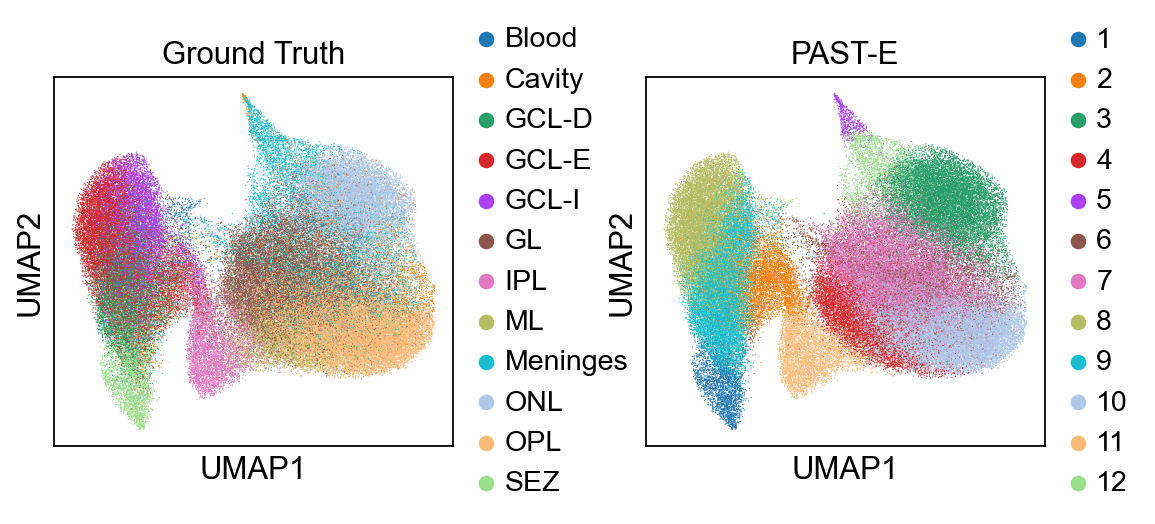

In [15]:
sc.pp.neighbors(sdata, use_rep='embedding')
sc.tl.umap(sdata)
sc.pl.umap(sdata, color=["annotation", "mclust"], title=["Ground Truth", "PAST-E"], wspace=0.35)

Visualization of spatial domains colored by annotation and PAST-derived clusters.

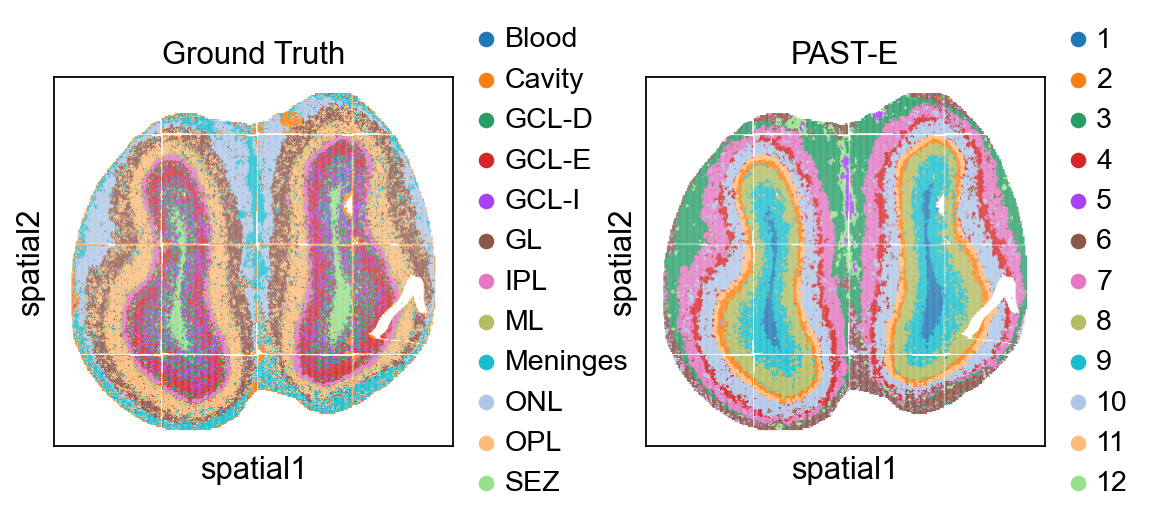

In [16]:
sc.pl.embedding(sdata, color=["annotation", "mclust"], basis="spatial", title=["Ground Truth", "PAST-E"], wspace=0.35)